In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
from google.colab import drive

In [2]:


# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Especificar la ruta del archivo en Drive
# Asegúrate de que la ruta sea correcta.
# Generalmente, los archivos estarán en '/content/drive/My Drive/'
file_path = '/content/drive/My Drive/Correspondencia-Julius.csv'

# Cargar el archivo CSV
try:
    df = pd.read_csv(file_path,encoding='iso-8859-1')

    # Verificar la estructura de los datos
    print("Dataset shape:", df.shape)
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nFirst few rows:")
    print(df.head())

except FileNotFoundError:
    print(f"Error: El archivo no se encontró en la ruta especificada: {file_path}")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (209, 8)

Column names:
['Fecha de llegada', 'De', 'De-Email', 'Para', 'Para-Email', 'Tema', 'Hilo', 'UltimoHilo']

First few rows:
   Fecha de llegada                         De                     De-Email  \
0  26/06/2024 00:44                Regula Team  request@regulaforensics.com   
1  25/06/2024 11:07                Illia Tahil        illia.tahil@regula.us   
2  24/06/2024 11:45  Jose Manuel Lopez Basilio   manuel.basilio@novitech.mx   
3  21/06/2024 09:36  Jose Manuel Lopez Basilio   manuel.basilio@novitech.mx   
4  20/06/2024 22:58        Vaidas idanavi?ius  VaidasZ@neurotechnology.com   

                        Para                               Para-Email  \
0        Arturo Frappe Muñoz                arturo.frappe@novitech.mx   
1  Jose Manuel Lopez Basilio               manuel.basilio@novitech.mx   
2        Arturo Frappe Muñoz  

Datos cargados y validados, generemos la red de vínculos

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 142 (\x8e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


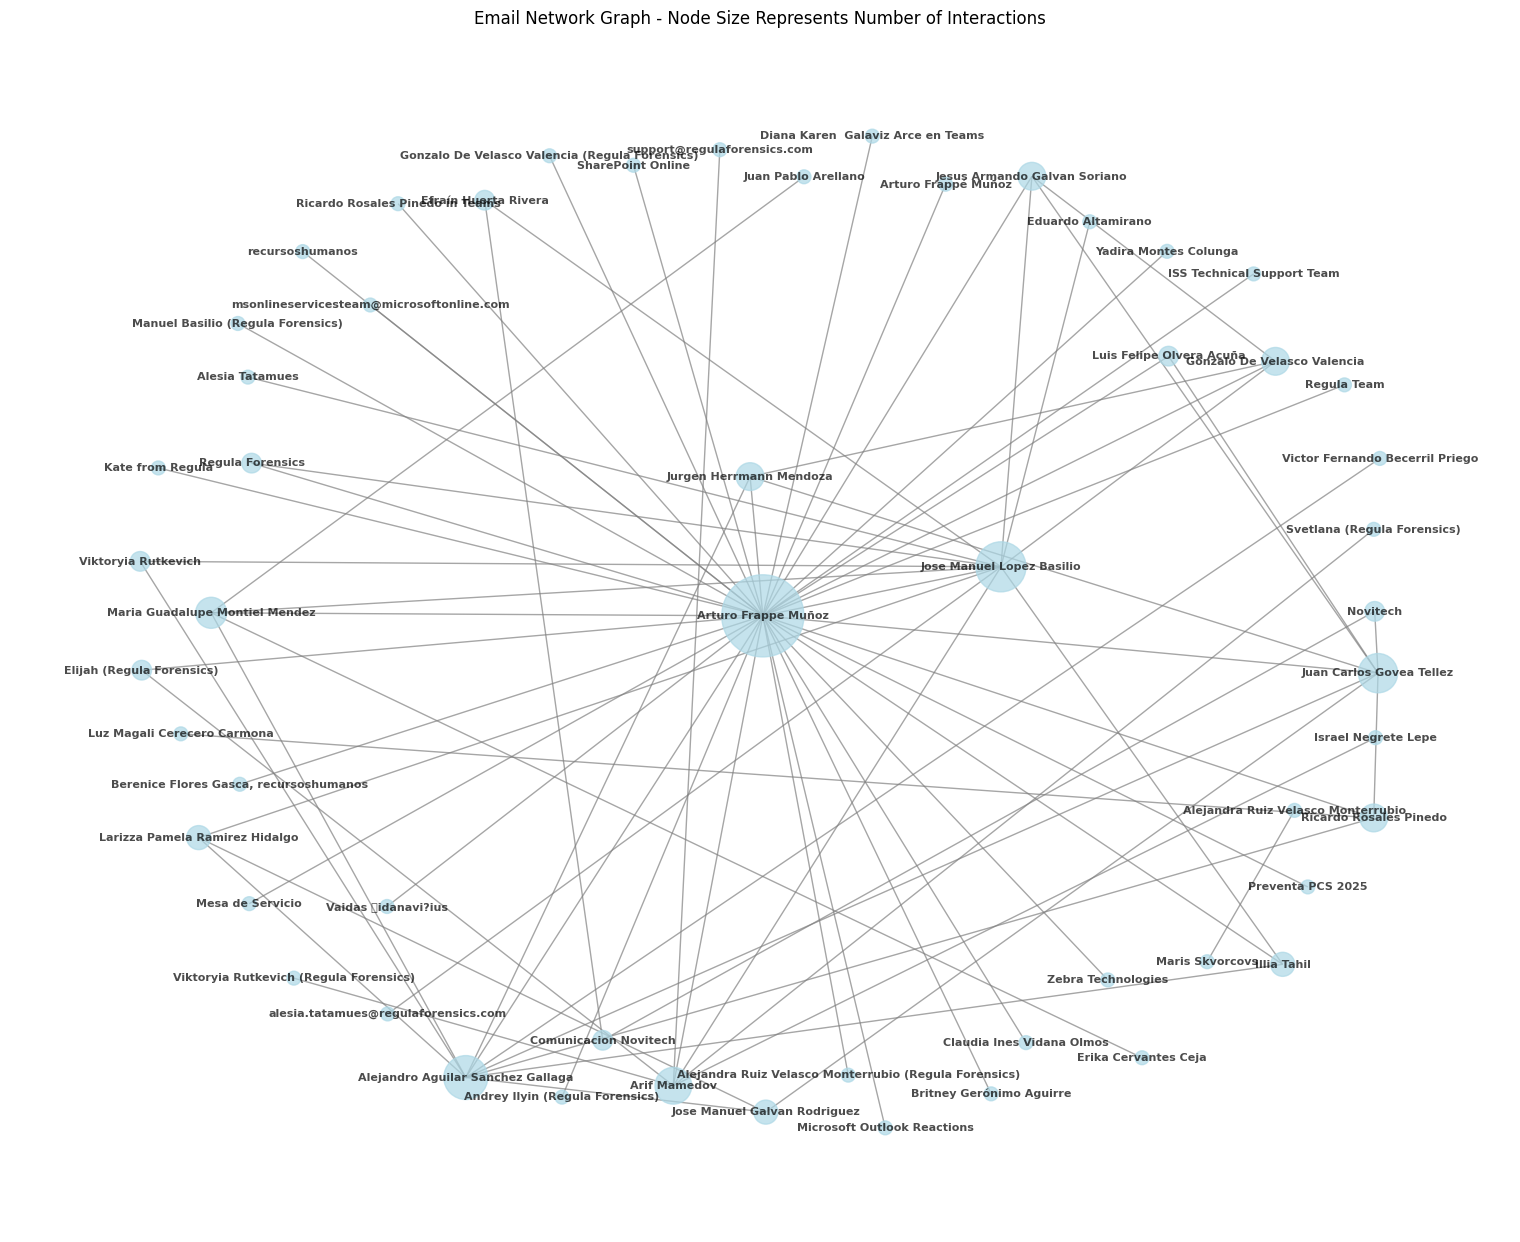

In [6]:
# Data preprocessing for network analysis
# Convert date column to datetime
df['Fecha de llegada'] = pd.to_datetime(df['Fecha de llegada'], errors='coerce')

# Extract day of week and hour
df['Day'] = df['Fecha de llegada'].dt.day_name()
df['Hour'] = df['Fecha de llegada'].dt.hour

# Create network graph
G = nx.Graph()

# Add edges between senders and receivers
for index, row in df.iterrows():
    sender = row['De']
    receiver = row['Para']
    if pd.notna(sender) and pd.notna(receiver):
        if G.has_edge(sender, receiver):
            G[sender][receiver]['weight'] += 1
        else:
            G.add_edge(sender, receiver, weight=1)

# Calculate node sizes based on degree (number of connections)
node_sizes = [G.degree(node) * 100 for node in G.nodes()]

# Create network visualization
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, k=3, iterations=50)
nx.draw(G, pos, node_size=node_sizes, node_color='lightblue',
        with_labels=True, font_size=8, font_weight='bold',
        edge_color='gray', alpha=0.7)
plt.title('Email Network Graph - Node Size Represents Number of Interactions')
plt.show()

La red de vínculos es un grafo no dirigido donde el la cantidad de emails aportan al radio de cada nodo, donde cada nodo es un remitente del buzón de correo. El nodo central corresponde al dueño del buzón.


In [8]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
# Find most influential nodes (top 10 by degree centrality)
top_influential = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
influential_df = pd.DataFrame(top_influential, columns=['Node', 'Degree_Centrality'])
print("\nTop 10 Most Influential Nodes:")
print(influential_df)


Top 10 Most Influential Nodes:
                                Node  Degree_Centrality
0                Arturo Frappe Muñoz           0.648148
1          Jose Manuel Lopez Basilio           0.240741
2  Alejandro Aguilar Sanchez Gallaga           0.185185
3           Juan Carlos Govea Tellez           0.148148
4                       Arif Mamedov           0.129630
5     Maria Guadalupe Montiel Mendez           0.092593
6             Ricardo Rosales Pinedo           0.074074
7            Jurgen Herrmann Mendoza           0.074074
8        Gonzalo De Velasco Valencia           0.074074
9       Jesus Armando Galvan Soriano           0.074074


Los nodos mas influyentes, incluyen al dueño del buzón, observe cuales son los nodos siguientes, ellos son los que mas influyen en esta red.

In [9]:
# Find second most influential node
second_most_influential = top_influential[1]
print(f"\nSecond most influential node: {second_most_influential[0]} with centrality: {second_most_influential[1]:.4f}")


Second most influential node: Jose Manuel Lopez Basilio with centrality: 0.2407


Solo como ejercicio, extraeremos al remitente mas influyente del buzón. Ahora analizaremos los temas mas recurrentes.

In [10]:
# Analyze most recurrent themes
theme_counts = df['Tema'].value_counts().reset_index()
theme_counts.columns = ['Tema', 'Count']
most_recurrent_theme = theme_counts.iloc[0]
print(f"\nMost recurrent theme: {most_recurrent_theme['Tema']} with {most_recurrent_theme['Count']} occurrences")


Most recurrent theme: Regula FACE API with 15 occurrences


Ahora analizaremos los días y las horas a las que llega el email para tener una idea general de lo que será nuestro tiempo libre.

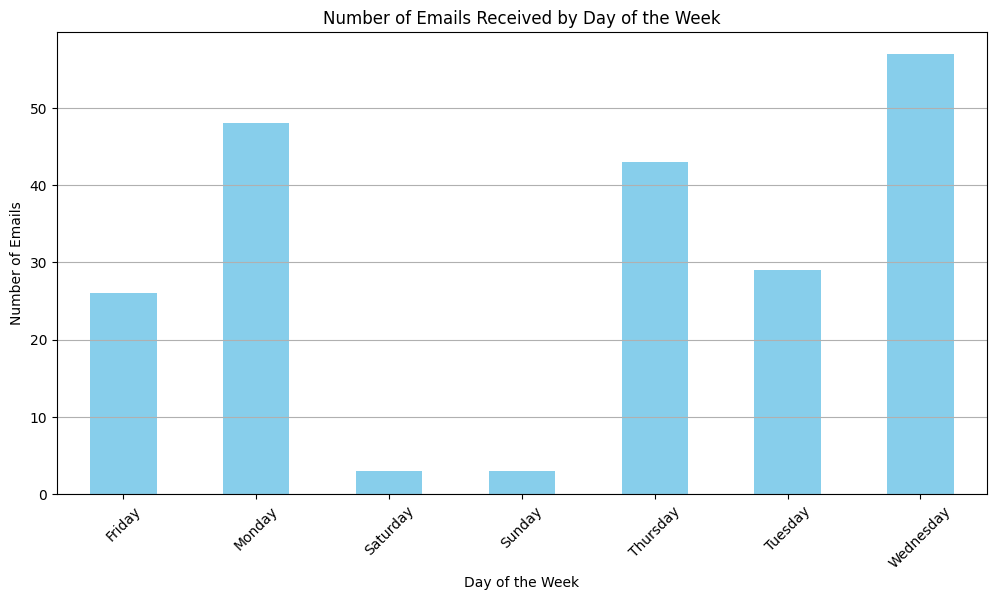

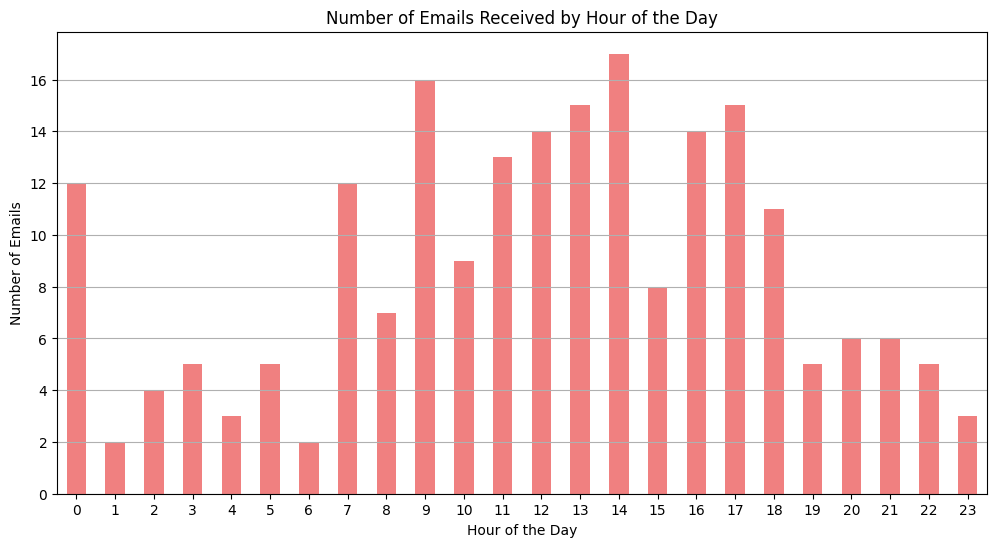

In [12]:
# Email arrival patterns analysis
# Count emails by day of week
emails_by_day = df['Day'].value_counts().sort_index()
emails_by_hour = df['Hour'].value_counts().sort_index()

# Visualize emails by day of week
plt.figure(figsize=(12, 6))
emails_by_day.plot(kind='bar', color='skyblue')
plt.title('Number of Emails Received by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Visualize emails by hour
plt.figure(figsize=(12, 6))
emails_by_hour.plot(kind='bar', color='lightcoral')
plt.title('Number of Emails Received by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Estas gráficas muestran los días y las horas a las que se recibe mas email, pero aún así no permiten sacar conclusiones rápidamente, hagamos un mapa de calor.


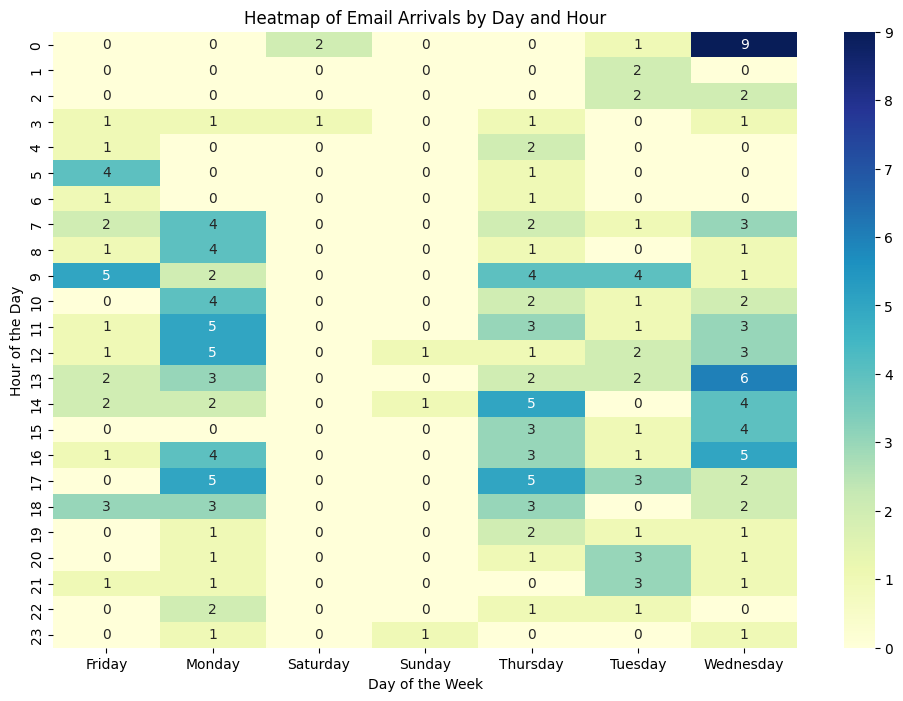

In [13]:
# Create heatmap for day vs hour analysis
heatmap_data = df.pivot_table(index='Hour', columns='Day', values='Tema', aggfunc='count', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Email Arrivals by Day and Hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

Parece que la noche de los martes para amanecer miércoles las respuestas se disparan en este mailbox, eso significa que el transcurso del miércoles tendremos toda la carga del email.

Ahora hagamos un análisis para saber como respondemos a esos emails.

<ipython-input-14-52be08d6a5ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipient_emails['Fecha de llegada'] = pd.to_datetime(recipient_emails['Fecha de llegada'], errors='coerce')
<ipython-input-14-52be08d6a5ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipient_emails['Day'] = recipient_emails['Fecha de llegada'].dt.day_name()
<ipython-input-14-52be08d6a5ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

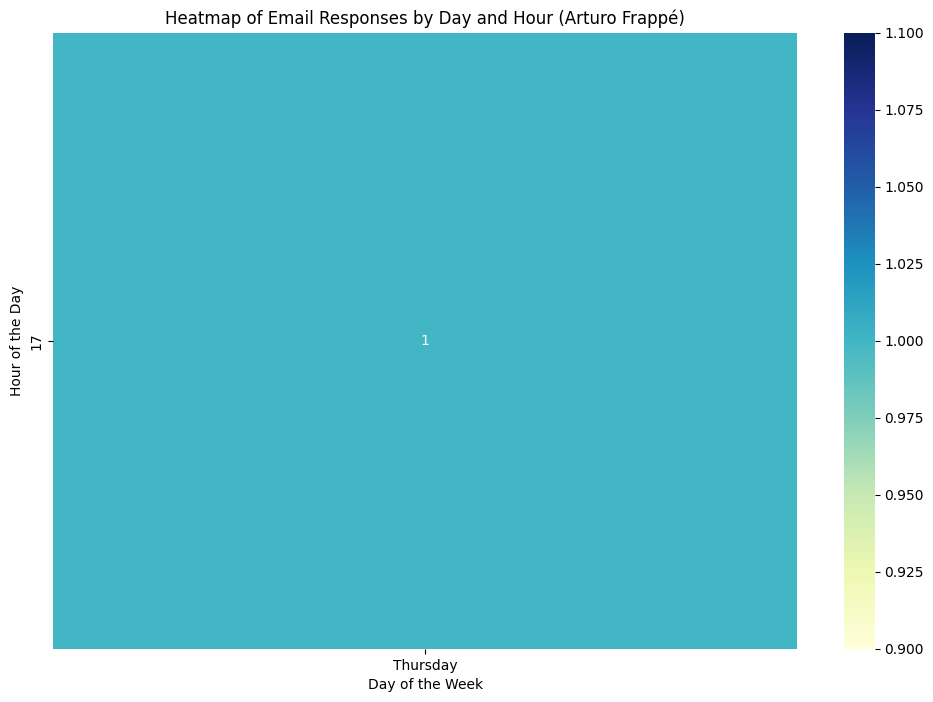

In [14]:
# Analyze Arturo Frappé's response patterns
recipient_emails = df[df['De'] == 'Arturo Frappé Muñoz']
recipient_emails['Fecha de llegada'] = pd.to_datetime(recipient_emails['Fecha de llegada'], errors='coerce')
recipient_emails['Day'] = recipient_emails['Fecha de llegada'].dt.day_name()
recipient_emails['Hour'] = recipient_emails['Fecha de llegada'].dt.hour

heatmap_data_recipient = recipient_emails.pivot_table(index='Hour', columns='Day', values='Tema', aggfunc='count', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_recipient, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Email Responses by Day and Hour (Arturo Frappé)')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

Sin comentarios, el dueño del buzón no responde a sus emails.

Analicemos ahora los patrones de respuesta de los otros participantes y saquemos conclusiones.

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 142 (\x8e) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 142 (\x8e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


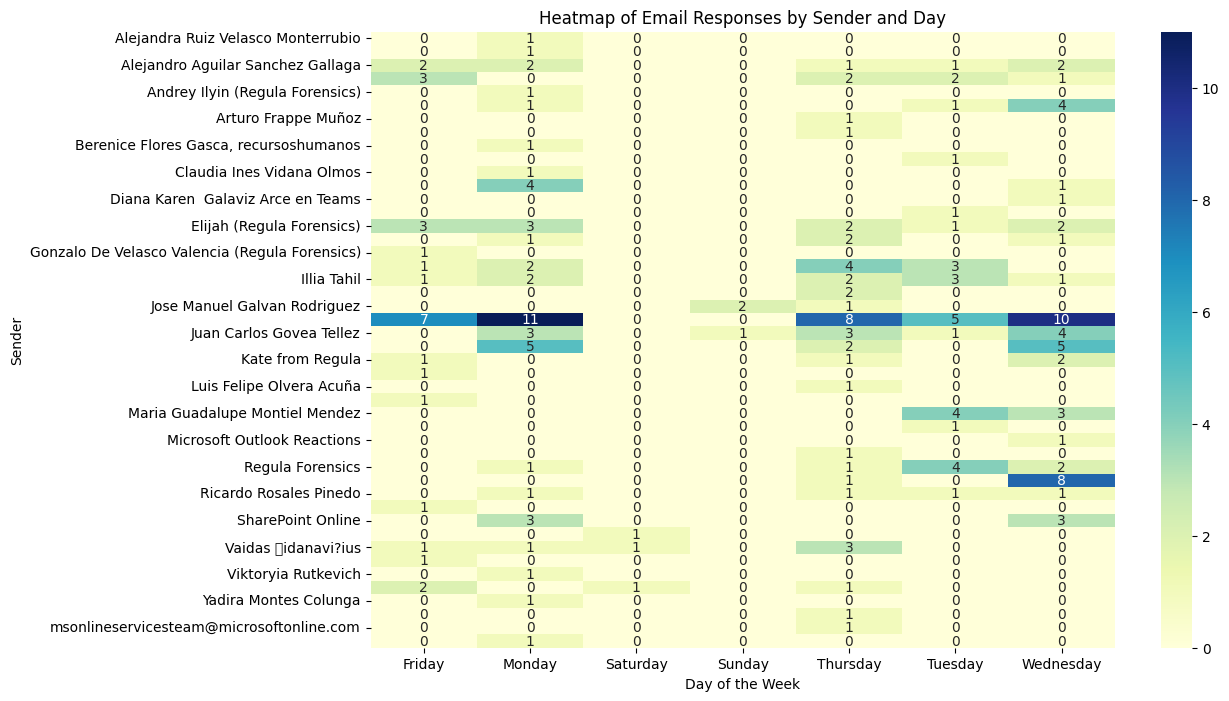

In [15]:
# Compare response patterns by sender
response_patterns = df.pivot_table(index='De', columns='Day', values='Tema', aggfunc='count', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(response_patterns, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Email Responses by Sender and Day')
plt.xlabel('Day of the Week')
plt.ylabel('Sender')
plt.show()


Los colores mas obscuros representan a los nodos o participantes que mas tráfico generan, al visualizar esto, quizas sea mejor organizar una reunión con estos nodos.

Fin del análisis